In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

0it [00:00, ?it/s]

9920512it [00:01, 6508735.51it/s]                             


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 62264.23it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw


1654784it [00:01, 1333655.73it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


8192it [00:00, 33574.60it/s]            

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw
Processing...
Done!


## Common setup

In [135]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
from sklearn.decomposition import PCA
from openTSNE.callbacks import ErrorLogger

import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


def extract_embeddingsx(dataloader, model, reduction='pca'):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 32))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    if reduction == 'pca':
        pca = PCA(n_components=2)
        embeddings = pca.fit_transform(embeddings)
    elif reduction == 'tsne':
        otsne = OTSNE(initialization='pca', 
#                       metric="cosine", 
                      n_jobs=8,
                      callbacks=ErrorLogger(), 
                      negative_gradient_method='bh')
        embeddings = otsne.fit(embeddings)
    else:
        raise Exception
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [110]:
from torch.nn import MultiMarginLoss
lossfn = MultiMarginLoss(p=1,margin=0, reduction='none')
x = torch.randint(0, 10, (2, 5))+0.0
y = torch.tensor([0, 0])
print(x)
lossfn(x, y)

tensor([[5., 6., 0., 2., 8.],
        [0., 3., 0., 4., 8.]])


tensor([0.8000, 3.0000])

In [136]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNetX, ClassificationNetX

from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNetX()
model = ClassificationNetX(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
# loss_fn = torch.nn.MultiMarginLoss(p=1, margin=0)
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 50

fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/60000 (0%)]	Loss: 2.314431	Accuracy: 8.984375
Train: [12800/60000 (21%)]	Loss: 1.178745	Accuracy: 61.65747549019608
Train: [25600/60000 (43%)]	Loss: 0.165144	Accuracy: 78.19074876237623
Train: [38400/60000 (64%)]	Loss: 0.100792	Accuracy: 84.42156456953643
Train: [51200/60000 (85%)]	Loss: 0.069470	Accuracy: 87.79345460199005
Epoch: 1/10. Train set: Average loss: 0.3419	Accuracy: 89.24
Epoch: 1/10. Validation set: Average loss: 0.0558	Accuracy: 98.21
Train: [0/60000 (0%)]	Loss: 0.081777	Accuracy: 96.875
Train: [12800/60000 (21%)]	Loss: 0.071095	Accuracy: 97.88602941176471
Train: [25600/60000 (43%)]	Loss: 0.066398	Accuracy: 97.98499381188118
Train: [38400/60000 (64%)]	Loss: 0.051130	Accuracy: 98.17104718543047
Train: [51200/60000 (85%)]	Loss: 0.050481	Accuracy: 98.28397077114428
Epoch: 2/10. Train set: Average loss: 0.0588	Accuracy: 98.31833333333333
Epoch: 2/10. Validation set: Average loss: 0.0864	Accuracy: 97.43
Train: [0/60000 (0%)]	Loss: 0.056172	Accuracy: 98.4375
Train: [1

Iteration   50, KL divergence  4.4860, 50 iterations in 1.8749 sec
Iteration  100, KL divergence  3.5792, 50 iterations in 1.9702 sec
Iteration  150, KL divergence  3.3114, 50 iterations in 1.6573 sec
Iteration  200, KL divergence  3.1798, 50 iterations in 1.9004 sec
Iteration  250, KL divergence  3.0964, 50 iterations in 1.9268 sec
Iteration   50, KL divergence  2.4241, 50 iterations in 2.0748 sec
Iteration  100, KL divergence  2.0514, 50 iterations in 1.8182 sec
Iteration  150, KL divergence  1.7977, 50 iterations in 2.0212 sec
Iteration  200, KL divergence  1.6214, 50 iterations in 1.9829 sec
Iteration  250, KL divergence  1.4931, 50 iterations in 2.0681 sec
Iteration  300, KL divergence  1.3958, 50 iterations in 2.0669 sec
Iteration  350, KL divergence  1.3198, 50 iterations in 1.8920 sec
Iteration  400, KL divergence  1.2586, 50 iterations in 1.9887 sec
Iteration  450, KL divergence  1.2085, 50 iterations in 2.1461 sec
Iteration  500, KL divergence  1.1665, 50 iterations in 1.9424

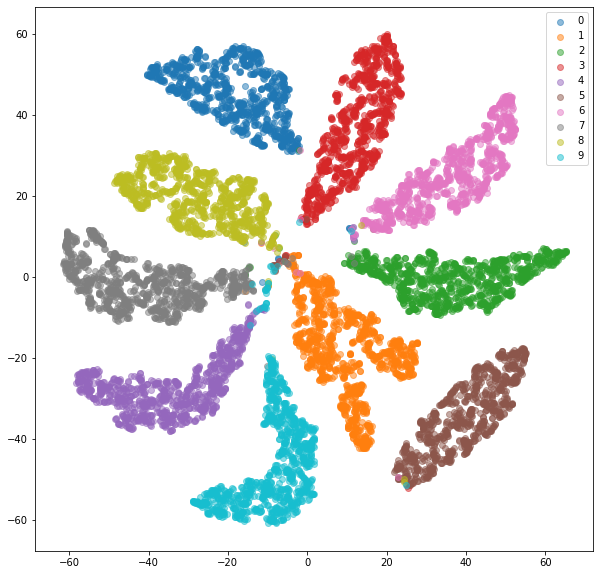

In [137]:
# train_embeddings_baseline, train_labels_baseline = extract_embeddingsx(train_loader, model)
# plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddingsx(test_loader, model, 'tsne')
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [138]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNetX()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 100

fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will res

Train: [0/60000 (0%)]	Loss: 0.170865
Train: [12800/60000 (21%)]	Loss: 0.051247
Train: [25600/60000 (43%)]	Loss: 0.026452
Train: [38400/60000 (64%)]	Loss: 0.018486
Train: [51200/60000 (85%)]	Loss: 0.013781
Epoch: 1/10. Train set: Average loss: 0.0252
Epoch: 1/10. Validation set: Average loss: 0.0096
Train: [0/60000 (0%)]	Loss: 0.008830
Train: [12800/60000 (21%)]	Loss: 0.009403
Train: [25600/60000 (43%)]	Loss: 0.007389
Train: [38400/60000 (64%)]	Loss: 0.006807
Train: [51200/60000 (85%)]	Loss: 0.005876
Epoch: 2/10. Train set: Average loss: 0.0070
Epoch: 2/10. Validation set: Average loss: 0.0064
Train: [0/60000 (0%)]	Loss: 0.005154
Train: [12800/60000 (21%)]	Loss: 0.005208
Train: [25600/60000 (43%)]	Loss: 0.005117
Train: [38400/60000 (64%)]	Loss: 0.004118
Train: [51200/60000 (85%)]	Loss: 0.004335
Epoch: 3/10. Train set: Average loss: 0.0045
Epoch: 3/10. Validation set: Average loss: 0.0044
Train: [0/60000 (0%)]	Loss: 0.001941
Train: [12800/60000 (21%)]	Loss: 0.003509
Train: [25600/60000 (

Iteration   50, KL divergence  4.2307, 50 iterations in 2.3049 sec
Iteration  100, KL divergence  3.6764, 50 iterations in 2.1998 sec
Iteration  150, KL divergence  3.5472, 50 iterations in 2.0204 sec
Iteration  200, KL divergence  3.4836, 50 iterations in 2.0144 sec
Iteration  250, KL divergence  3.4415, 50 iterations in 2.3955 sec
Iteration   50, KL divergence  2.7822, 50 iterations in 2.0065 sec
Iteration  100, KL divergence  2.5278, 50 iterations in 2.1249 sec
Iteration  150, KL divergence  2.3380, 50 iterations in 2.0523 sec
Iteration  200, KL divergence  2.2033, 50 iterations in 2.0576 sec
Iteration  250, KL divergence  2.1032, 50 iterations in 1.7317 sec
Iteration  300, KL divergence  2.0260, 50 iterations in 2.1505 sec
Iteration  350, KL divergence  1.9644, 50 iterations in 2.4149 sec
Iteration  400, KL divergence  1.9143, 50 iterations in 2.0319 sec
Iteration  450, KL divergence  1.8724, 50 iterations in 1.8785 sec
Iteration  500, KL divergence  1.8370, 50 iterations in 1.9966

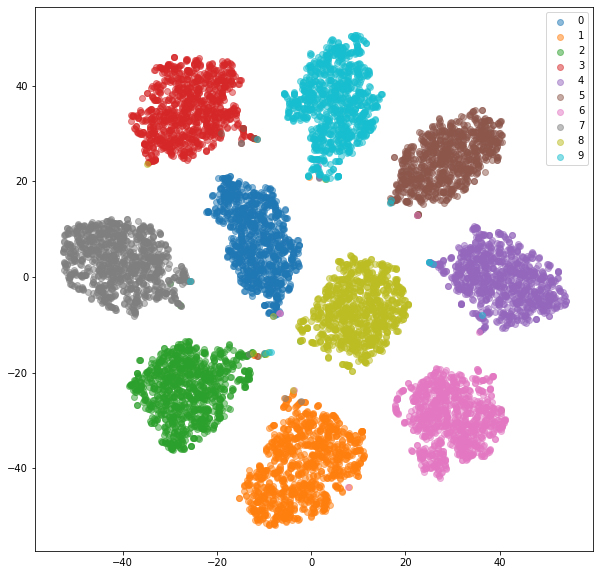

In [134]:
# train_embeddings_cl, train_labels_cl = extract_embeddingsx(train_loader, model)
# plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddingsx(test_loader, model, 'tsne')
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [44]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 1
log_interval = 100

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [45]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/60000 (0%)]	Loss: 0.999425
Train: [12800/60000 (21%)]	Loss: 0.327708
Train: [25600/60000 (43%)]	Loss: 0.158101
Train: [38400/60000 (64%)]	Loss: 0.111365
Train: [51200/60000 (85%)]	Loss: 0.092960
Epoch: 1/1. Train set: Average loss: 0.1598
Epoch: 1/1. Validation set: Average loss: 0.0777


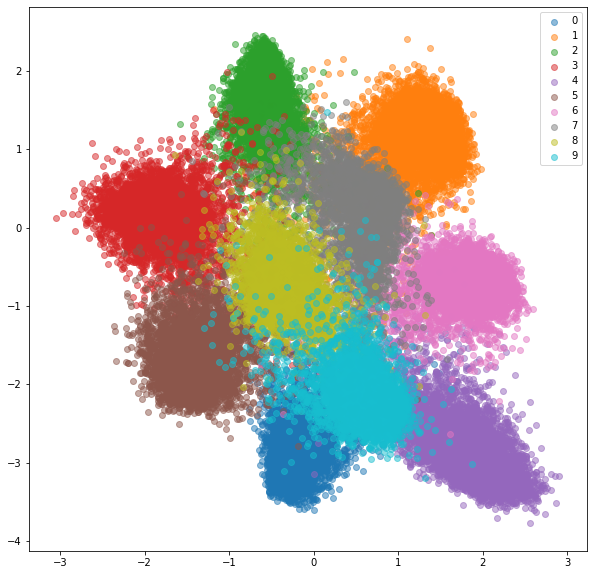

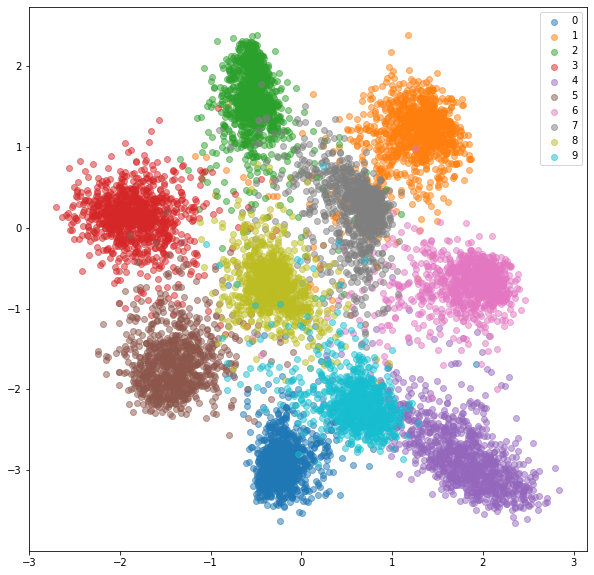

In [46]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [14]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491550
Train: [12500/60000 (21%)]	Loss: 0.270060
Train: [25000/60000 (42%)]	Loss: 0.139297
Train: [37500/60000 (62%)]	Loss: 0.096533
Train: [50000/60000 (83%)]	Loss: 0.076680
Epoch: 1/20. Train set: Average loss: 0.1338
Epoch: 1/20. Validation set: Average loss: 0.0537
Train: [0/60000 (0%)]	Loss: 0.052101
Train: [12500/60000 (21%)]	Loss: 0.052579
Train: [25000/60000 (42%)]	Loss: 0.047850
Train: [37500/60000 (62%)]	Loss: 0.037767
Train: [50000/60000 (83%)]	Loss: 0.037061
Epoch: 2/20. Train set: Average loss: 0.0418
Epoch: 2/20. Validation set: Average loss: 0.0325
Train: [0/60000 (0%)]	Loss: 0.015191
Train: [12500/60000 (21%)]	Loss: 0.027951
Train: [25000/60000 (42%)]	Loss: 0.025129
Train: [37500/60000 (62%)]	Loss: 0.026858
Train: [50000/60000 (83%)]	Loss: 0.024246
Epoch: 3/20. Train set: Average loss: 0.0254
Epoch: 3/20. Validation set: Average loss: 0.0274
Train: [0/60000 (0%)]	Loss: 0.010963
Train: [12500/60000 (21%)]	Loss: 0.019170
Train: [25000/60000 (

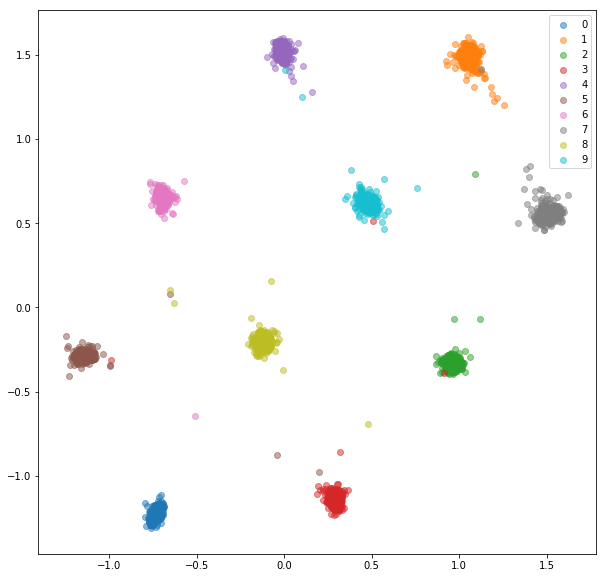

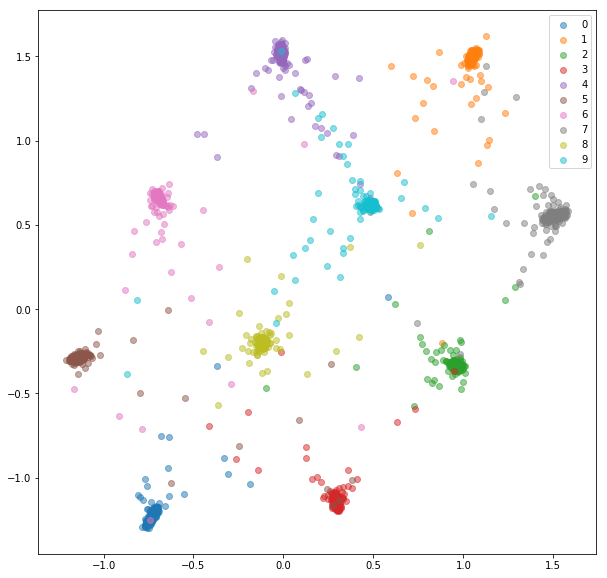

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [16]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999806	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.989613	Average nonzero triplets: 2648.725490196078
Train: [25000/60000 (42%)]	Loss: 0.994085	Average nonzero triplets: 2328.5346534653463
Train: [37500/60000 (62%)]	Loss: 0.958655	Average nonzero triplets: 2115.5165562913908
Train: [50000/60000 (83%)]	Loss: 0.976330	Average nonzero triplets: 1921.4925373134329
Epoch: 1/20. Train set: Average loss: 0.9805	Average nonzero triplets: 1801.7071129707113
Epoch: 1/20. Validation set: Average loss: 0.8326	Average nonzero triplets: 1218.6410256410256
Train: [0/60000 (0%)]	Loss: 0.876484	Average nonzero triplets: 1217.0
Train: [12500/60000 (21%)]	Loss: 0.991039	Average nonzero triplets: 975.3529411764706
Train: [25000/60000 (42%)]	Loss: 0.992353	Average nonzero triplets: 934.009900990099
Train: [37500/60000 (62%)]	Loss: 1.075175	Average nonzero triplets: 917.0596026490066
Train: [50000/60000 (83%)]	Loss: 1.023091	Average nonzero triplets: 889

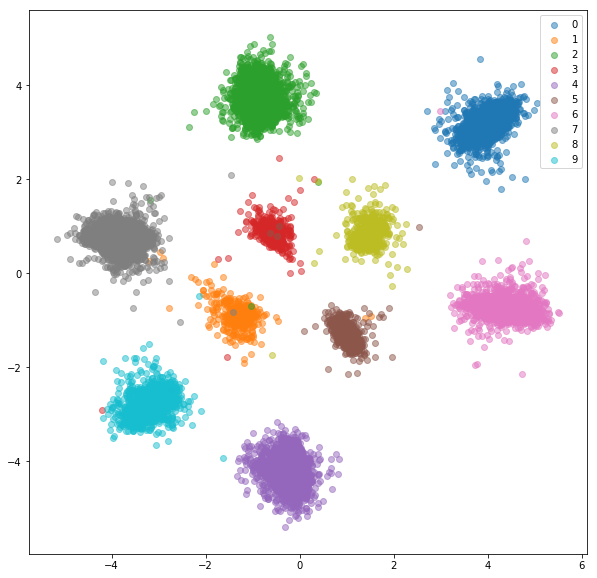

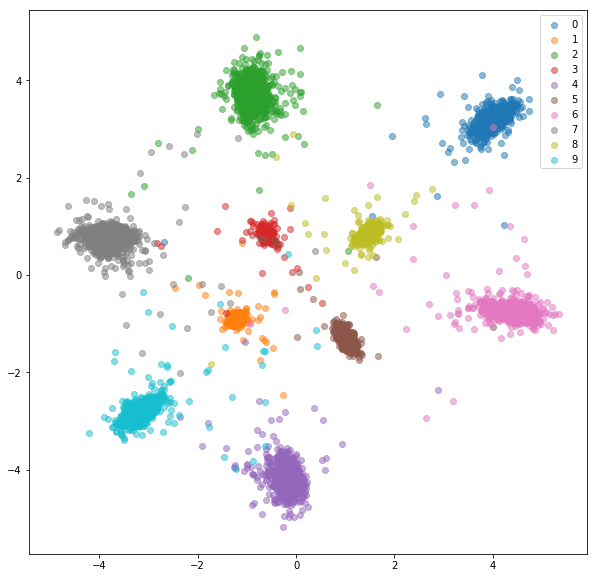

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

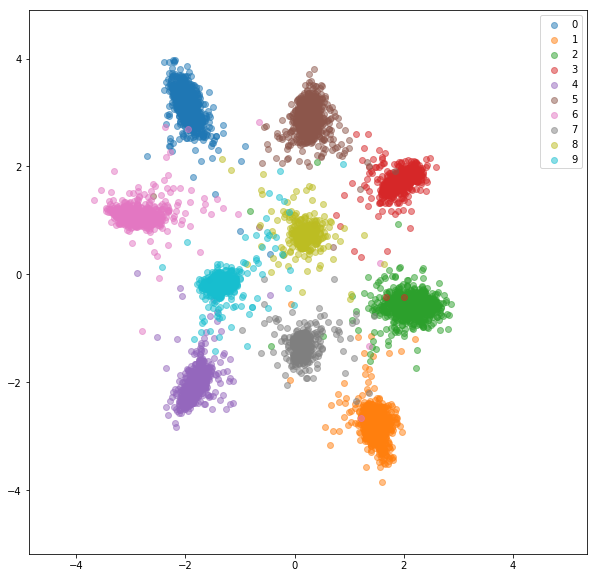

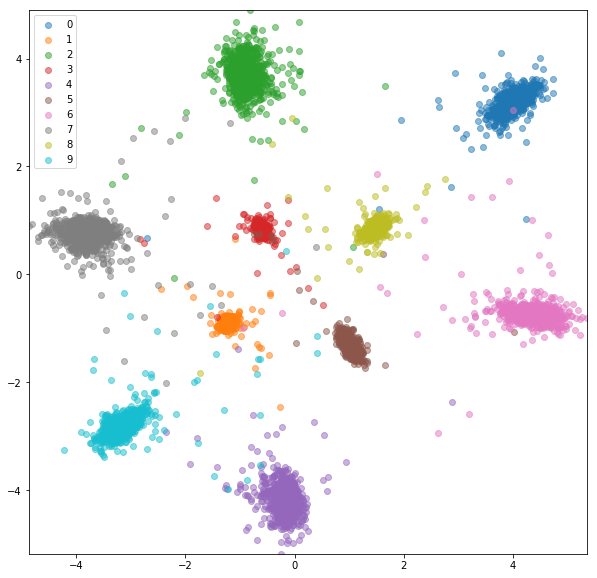

In [19]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

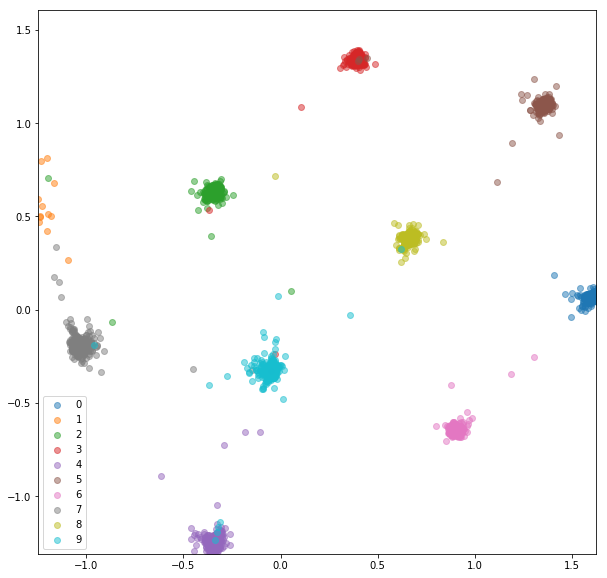

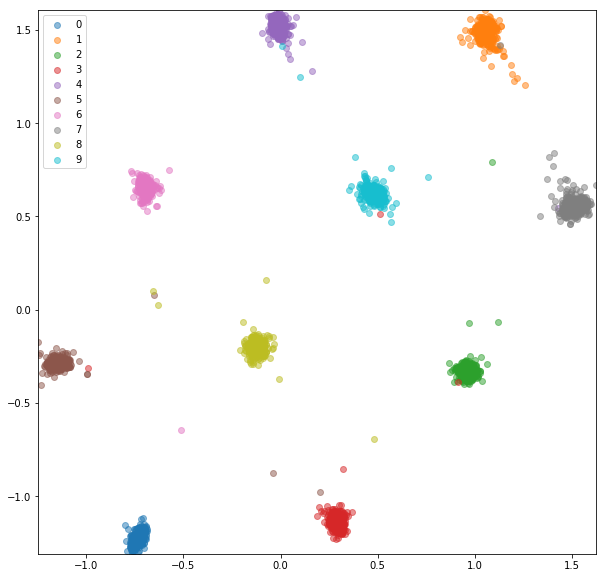

In [20]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)